In [1]:
import functools
import os
import numpy as np
import time
from absl import app
from absl import flags
from absl import logging

import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um

In [2]:

flags.DEFINE_integer('ensemble_size', 6, 'Size of ensemble.')
flags.DEFINE_float('input_repetition_probability', 0.0,
                   'The probability that the inputs are identical for the'
                   'ensemble members.')
flags.DEFINE_integer('width_multiplier', 2, 'Integer to multiply the number of'
                                             'typical filters by. "k" in ResNet-n-k.')
flags.DEFINE_integer('per_core_batch_size', 128, 'Batch size per TPU core/GPU.')
flags.DEFINE_integer('batch_repetitions', 4, 'Number of times an example is'
                                             'repeated in a training batch. More repetitions lead to'
                                             'lower variance gradients and increased training time.')
flags.DEFINE_integer('seed', 0, 'Random seed.')
flags.DEFINE_float('base_learning_rate', 0.1,
                   'Base learning rate when total training batch size is 128.')
flags.DEFINE_integer(
    'lr_warmup_epochs', 1,
    'Number of epochs for a linear warmup to the initial '
    'learning rate. Use 0 to do no warmup.')
flags.DEFINE_float('lr_decay_ratio', 0.2, 'Amount to decay learning rate.')
flags.DEFINE_list('lr_decay_epochs', ['80', '160', '180'],
                  'Epochs to decay learning rate by.')
flags.DEFINE_float('l2', 3e-4, 'L2 coefficient.')
flags.DEFINE_enum(
    'dataset', 'mnist', enum_values=['cifar10', 'cifar100', 'mnist'], help='Dataset.')
# TODO(ghassen): consider adding CIFAR-100-C to TFDS.
flags.DEFINE_string(
    'cifar100_c_path', '',
    'Path to the TFRecords files for CIFAR-100-C. Only valid '
    '(and required) if dataset is cifar100 and corruptions.')
flags.DEFINE_integer(
    'corruptions_interval', 50,
    'Number of epochs between evaluating on the corrupted '
    'test data. Use -1 to never evaluate.')
flags.DEFINE_integer(
    'checkpoint_interval', 50,
    'Number of epochs between saving checkpoints. Use -1 to '
    'never save checkpoints.')
flags.DEFINE_integer('num_bins', 15, 'Number of bins for ECE.')
flags.DEFINE_string(
    'output_dir', '/home/jupyter/mnist/WRN28-2/M6', 'The directory where the model weights and '
                                'training/evaluation summaries are stored.')
flags.DEFINE_integer('train_epochs', 200, 'Number of training epochs.')

# Accelerator flags.
flags.DEFINE_bool('use_gpu', True, 'Whether to run on GPU or otherwise TPU.')
flags.DEFINE_bool('use_bfloat16', False, 'Whether to use mixed precision.')
flags.DEFINE_integer('num_cores', 8, 'Number of TPU cores or number of GPUs.')
flags.DEFINE_string('tpu', None,
                    'Name of the TPU. Only used if use_gpu is False.')
FLAGS = flags.FLAGS


In [3]:
ensemble_size = 2
image_shape=[28,28,1]
width_multiplier=2
num_classes=10
output_dir='/home/jupyter/mnist/WRN28-2/M2'

In [7]:

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

#model.summary()
logging.info('Model input shape: %s', model.input_shape)
logging.info('Model output shape: %s', model.output_shape)
logging.info('Model number of weights: %s', model.count_params())

2021-11-29 15:15:44.839611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 15:15:44.887711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 15:15:44.888572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 15:15:44.890615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
initial_epoch = 0

In [12]:
 checkpoint.restore(latest_checkpoint)

In [25]:

images, labels = inputs
images = tf.tile(
    tf.expand_dims(images, 1), [1, FLAGS.ensemble_size, 1, 1, 1])
logits = checkpoint.model(images, training=False)
if FLAGS.use_bfloat16:
    logits = tf.cast(logits, tf.float32)
probs = tf.nn.softmax(logits)

if dataset_name == 'clean':
    per_probs = tf.transpose(probs, perm=[1, 0, 2])
    metrics['test/diversity'].add_batch(per_probs)

for i in range(FLAGS.ensemble_size):
    member_probs = probs[:, i]
    member_loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, member_probs)
    metrics['test/nll_member_{}'.format(i)].update_state(member_loss)
    metrics['test/accuracy_member_{}'.format(i)].update_state(
        labels, member_probs)

# Negative log marginal likelihood computed in a numerically-stable way.
labels_tiled = tf.tile(
    tf.expand_dims(labels, 1), [1, FLAGS.ensemble_size])
log_likelihoods = -tf.keras.losses.sparse_categorical_crossentropy(
    labels_tiled, logits, from_logits=True)
negative_log_likelihood = tf.reduce_mean(
    -tf.reduce_logsumexp(log_likelihoods, axis=[1]) +
    tf.math.log(float(FLAGS.ensemble_size)))
probs = tf.math.reduce_mean(probs, axis=1)  # marginalize

In [26]:
tf.reduce_mean(tf.reduce_sum(
                    tf.keras.losses.sparse_categorical_crossentropy(
                        labels, logits, from_logits=True), axis=1))

ValueError: Shape mismatch: The shape of labels (received (20, 1)) should equal the shape of logits except for the last dimension (received (20, 2, 10)).

In [ ]:

def load_not_mnist(corruption_name,
                   corruption_intensity,
                   batch_size,
                   use_bfloat16,
                   drop_remainder=False,
                   normalize=True):
  """Loads mnist-C dataset."""
  if use_bfloat16:
    dtype = tf.bfloat16
  else:
    dtype = tf.float32
  corruption = corruption_name #+ '_' + str(corruption_intensity)
  def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype)
    if normalize:
      # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
      # and std = np.std(train_images, axis=(0,1,2)).
      mean = tf.constant([0.1307], dtype=dtype)
      std = tf.constant([0.3081], dtype=dtype)
      # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
      # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
      # However, we change convention to use the std over the entire training
      # set instead.
      image = (image - mean) / std
    label = tf.cast(label, dtype)
    return image, label

  dataset = tfds.load(name='mnist_corrupted/{}'.format(corruption),
                      split=tfds.Split.TEST,
                      as_supervised=True,
                      download=True)
  dataset = dataset.map(
      preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [2]:

import numpy as np
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt

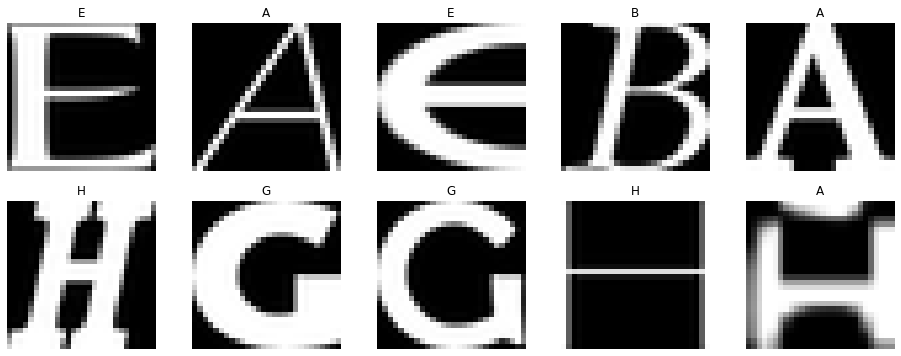

In [3]:
im_root = '/home/jupyter/tensorflow_datasets/not_mnist/notMNIST_small'
dirs = os.listdir(im_root)
fig, ax = plt.subplots(2, 5, figsize=(16, 6))

for i in range(2):
    for j in range(5):
        dr = random.choice(dirs)
        im = random.choice(os.listdir(os.path.join(im_root, dr)))
        ax[i, j].imshow(plt.imread(os.path.join(im_root, dr, im)), cmap='gray')
        ax[i, j].set_title(dr)
        ax[i, j].axis('off')

In [ ]:
import imghdr
dirs = os.listdir(im_root)
label_dict = defaultdict()

# filenames = tf.constant(['im_01.jpg', 'im_02.jpg', 'im_03.jpg', 'im_04.jpg'])
# labels = tf.constant([0, 1, 0, 1])
filenames=[]
labels=[]
images=[]
c=0
for idx, dr in enumerate(dirs):
    print(dr)
    label_dict[idx] = dr
    ims = os.listdir(os.path.join(im_root, dr))
    random.shuffle(ims)
    for im in (ims):
        # 
        image_string = tf.io.read_file(os.path.join(im_root, dr, im))
        try:
            tf.io.decode_image(image_string)
        except:
            continue
        filenames.append(os.path.join(im_root, dr, im))
        labels.append(idx)
        
filenames = tf.constant(filenames)
labels = tf.constant(labels) 
# images = tf.constant(images) 
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
use_bfloat16=True
normalize=True

if use_bfloat16:
    dtype = tf.bfloat16
else:
    dtype = tf.float32

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image = tf.io.decode_image(image_string, dtype=dtype)

    # image = tf.image.convert_image_dtype(image_decoded, dtype)
    if normalize:
      # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
      # and std = np.std(train_images, axis=(0,1,2)).
      mean = tf.constant([0.1307], dtype=dtype)
      std = tf.constant([0.3081], dtype=dtype)
      # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
      # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
      # However, we change convention to use the std over the entire training
      # set instead.
      image = (image - mean) / std
    label = tf.cast(label, dtype)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(3)

I
E
D
C
G
F
A
J
H
B


array([9, 9, 9], dtype=bfloat16)

In [24]:
a=list(dataset.as_numpy_iterator())[-10:]





In [29]:
# list(dataset.as_numpy_iterator())
dataset
filenames[0]
f="Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png"
image_string = tf.io.read_file(filenames[0])
image_string
image = tf.io.decode_png(image_string)



In [48]:
filenames = tf.constant(['im_01.jpg', 'im_02.jpg', 'im_03.jpg', 'im_04.jpg'])
labels = tf.constant([0, 1, 0, 1])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
# dataset = dataset.batch(2)
dataset
# step 4: create iterator and final input tensor
# iterator = dataset.make_one_shot_iterator()
# images, labels = iterator.get_next()

<MapDataset shapes: ((None, None, 1), ()), types: (tf.float32, tf.int32)>